In [1]:
import numpy as np
import PIL
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import random

MAIN_PATH = "../Pr1/celebaa"

In [2]:
image_paths = glob(MAIN_PATH+"/*")

In [3]:
len(image_paths)

202599

In [4]:
def readImage(path,image_size=(256,256)):
    img = np.asarray(PIL.Image.open(path).resize(image_size))
    img = ((img - 127.5) / 127.5).astype("float32")
    return img

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


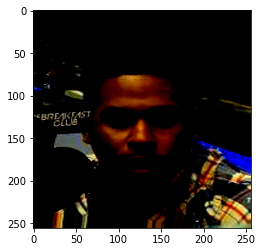

In [5]:
test_img = readImage("../Pr1/celebaa/000808.jpg")
print(test_img.shape)

plt.imshow(test_img)
plt.show()

In [6]:
BATCH_SIZE = 128
STEPS_PER_EPOCH = 500
print("Steps per epochh are",STEPS_PER_EPOCH)
def dataGenerator(batch_size):
    while True:
        paths = random.choices(image_paths,k=batch_size)
        batch = []
        for p in paths:
            batch.append(readImage(p))
        
        yield np.asarray(batch)

dataGen = dataGenerator(BATCH_SIZE)
print(next(dataGen).shape)

Steps per epochh are 500
(128, 256, 256, 3)


In [7]:
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.2)
def make_generator():
    model = tf.keras.Sequential()
    
    # Random noise to 16x16x256 image
    model.add(layers.Dense(16*16*256,use_bias=False,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((16,16,256)))
    
    assert model.output_shape == (None,16,16,256)
    
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(2,2),use_bias=False,padding="same",kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    assert model.output_shape == (None,32,32,128)
    
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(2,2),use_bias=False,padding="same",kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    assert model.output_shape == (None,64,64,128)
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),use_bias=False,padding="same",kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    assert model.output_shape == (None,128,128,64)
    
    model.add(layers.Conv2DTranspose(3,(5,5),strides=(2,2),use_bias=False,padding="same",kernel_initializer=WEIGHT_INIT,
                                     activation="tanh"
                                    ))
             
    assert model.output_shape == (None,256,256,3)
    return model

In [8]:
generator = make_generator()

C:\Users\maxih\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [9]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 65536)             6553600   
                                                                 
 batch_normalization (BatchN  (None, 65536)            262144    
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 65536)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 128)      819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      5

In [10]:

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):

    return cross_entropy(tf.ones_like(fake_output),fake_output)

gen_optimizer = tf.keras.optimizers.Adam(lr=1e-4)

In [11]:
def make_discriminator():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding="same",input_shape=(256,256,3)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(265,(5,5),strides=(2,2),padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model


In [12]:
discriminator = make_discriminator()

In [13]:
def discriminator_loss(real_images,fake_images):
    real_loss = cross_entropy(tf.ones_like(real_images),real_images)
    fake_loss = cross_entropy(tf.zeros_like(fake_images),fake_images)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
discriminator_optimizer = tf.keras.optimizers.Adam(lr=1e-4)

In [15]:
EPOCHS = 5
NOISE_DIM = 100

@tf.function
def train_step(images):

    noise = tf.random.normal([BATCH_SIZE,NOISE_DIM])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      
        generated_images = generator(noise,training=True)
       
        real_output = discriminator(images,training=True)
        fake_output = discriminator(generated_images,training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    
    gen_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

In [16]:
import time
import sys

def train(epochs):
    total_images = len(image_paths)
    steps_per_epoch = total_images // BATCH_SIZE

    for epoch in range(epochs):
        start = time.time()
        for step in range(steps_per_epoch):
            train_step(next(dataGen))
    
            sys.stdout.write(f"\rSTEP: {step}/{steps_per_epoch}")
            sys.stdout.flush()
            
        finish_time = round(time.time() - start, 2)
        print(f"Epoch {epoch}/{epochs} Process Time : {finish_time}")
        print("-"*15)
        

In [ ]:
train(EPOCHS)

STEP: 2/1582

In [74]:
train(3)

STEP: 1/2Epoch 0/3 Process Time : 70.92
---------------
STEP: 1/2Epoch 1/3 Process Time : 71.9
---------------
STEP: 1/2Epoch 2/3 Process Time : 78.91
---------------


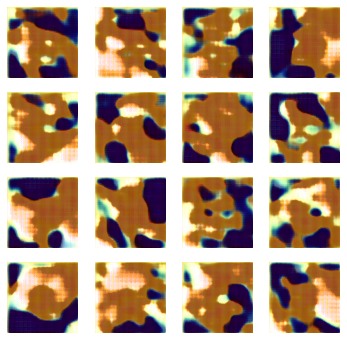

In [75]:
noise = tf.random.normal([16,100])
generated_images = np.asarray(generator(noise,training=False))

fig = plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow((generated_images[i,:,:,:]*127.5+127.5).astype("int"))
    plt.axis("off")
    
plt.show()